In [17]:
%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# create a tap list

Y = 8
X = 8
N = X * Y
LAMBDA = 2

def to_idx(x, y):
    return y * X + x

tap_list = [
    [(to_idx(1, 1), 1), (to_idx(6, 3), -1)],
    [(to_idx(2, 5), 1), (to_idx(5, 2), -1)]]
dims = len(tap_list)

In [19]:
# generate approximate encoders

approx_encs = NetBuilder.get_approx_encoders(tap_list, Y, X, LAMBDA)

Text(0.5,1,'first two dims')

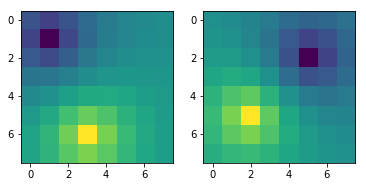

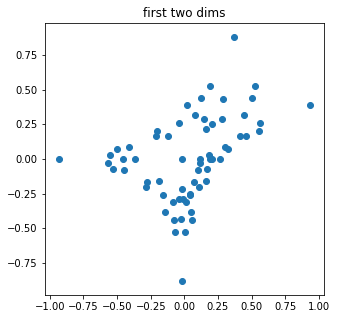

In [20]:
# plot the approximate encoders

yx_approx_encs = approx_encs.T.reshape((dims, Y, X))

fig, ax = plt.subplots(1, 2)
for d in range(dims):
    ax[d].imshow(yx_approx_encs[d, :, :].T)

# first two dims
plt.figure(figsize=(5,5))
plt.scatter(approx_encs[:, 0], approx_encs[:, 1])
plt.title('first two dims')

In [21]:
# get sample points
samples_per_enc = dims + 1
ANGLE_AWAY = np.pi / 6

sample_pts, thresh_encs = NetBuilder.get_sample_points_around_encs(approx_encs, ANGLE_AWAY, samples_per_enc)

Text(0.5,1,'first two dims\ntotal base encs = 9\ntotal sample points = 27')

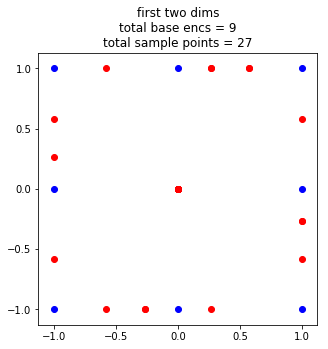

In [22]:
# plot resulting test points

plt.figure(figsize=(5, 5))
plt.scatter(thresh_encs[:, 0], thresh_encs[:, 1], c='b')
plt.scatter(sample_pts[:, 0], sample_pts[:, 1], c='r')
plt.title('first two dims' + 
          '\ntotal base encs = ' + str(thresh_encs.shape[0]) + 
          '\ntotal sample points = ' + str(sample_pts.shape[0]))
          

In [23]:
# now rig up a fake neuron response generator to test this on
# first just do ideal responses, no noise

offset_scale = 20
offsets = (2 * np.random.rand(N,) - 1) * offset_scale
gain_scale = 100
gains = np.random.rand(N,) * gain_scale

def nrn_fn(enc, offset, gain, x):
    return np.maximum(gain * np.dot(enc, x) + offset, 0)

firing_rates = np.zeros((sample_pts.shape[0], N))
for n in range(N):
    for s in range(sample_pts.shape[0]):
        firing_rates[s, n] = nrn_fn(approx_encs[n, :], offsets[n], gains[n], sample_pts[s, :])


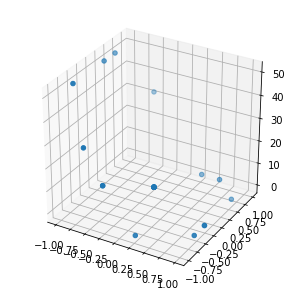

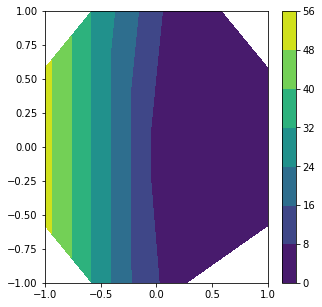

In [24]:
# plot neurons' behaviors

if dims == 2:
    
    # pick a neuron with a reasonable response
    nrn_idx = 0
    while True:
        if (np.abs(offsets[nrn_idx]) < .5 * offset_scale and 
            np.linalg.norm(approx_encs[nrn_idx, :]) > .2):
            break
        nrn_idx += 1
    #nrn_idx = np.random.randint(N)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    
    plt.figure(figsize=(5, 5))
    plt.tricontourf(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    plt.colorbar()

In [25]:
# try fitting, compare estimates to actual encoders 

baselines = np.maximum(offsets, 0)

est_encs, est_offsets, residuals, insufficient = NetBuilder.estimate_encs_from_tuning_curves(sample_pts, 
                                                                                             firing_rates, 
                                                                                             baselines, 
                                                                                             fired_tolerance=.1)

print(np.sum(insufficient), "/", est_encs.shape[0], "neurons needed more points")

9 / 64 neurons needed more points


[[-4.51378780e+01  5.32907052e-15]
 [-2.50210311e+01  1.30270832e+00]
 [-1.58574622e+01  3.19306011e+00]
 [-8.50495532e+00  6.77758717e+00]]
[[-45.13787801   0.        ]
 [-25.02103112   1.30270832]
 [-15.85746216   3.19306011]
 [ -8.50495532   6.77758717]]
[ 2.63915873e-14  1.52259158e-14 -7.81597009e-15 -6.80936788e-15]


(array([1., 4., 6., 7., 7., 9., 4., 5., 4., 8.]),
 array([-14.07263913, -10.68775128,  -7.30286344,  -3.91797559,
         -0.53308774,   2.85180011,   6.23668795,   9.6215758 ,
         13.00646365,  16.39135149,  19.77623934]),
 <a list of 10 Patch objects>)

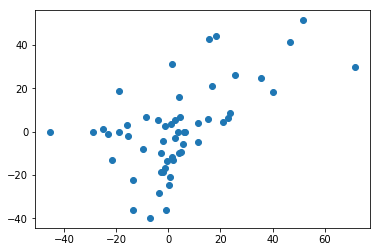

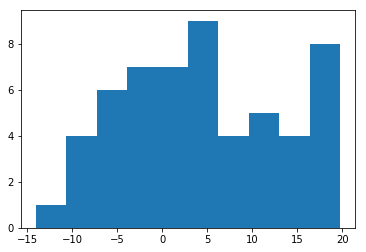

In [27]:
print(est_encs[:4, :])
print((approx_encs[:4, :].T * gains[:4]).T)
print(residuals[:4])

plt.figure()
plt.scatter(est_encs[:, 0], est_encs[:, 1])

plt.figure()
plt.hist(est_offsets[~np.isnan(est_offsets)])

In [2]:
# now try the same thing with the chip

%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

(4, 4, 2)


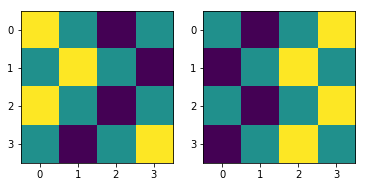

In [3]:
# test the D > 1 create_default_yx_taps function (with no bad taps)
# this is in the SY, SX space, not Y,X space

np.random.seed(1)

Y = 8
X = 8
D = 2
FMAX = 1000 # should determine from syn_tau

SY = Y // 2
SX = X // 2

yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=np.array([[False] * SY] * SX, dtype=bool))
print(yx_taps.shape)

if D == 1:
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])

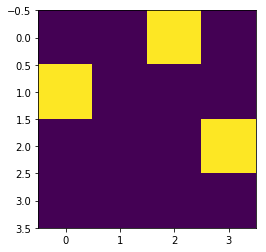

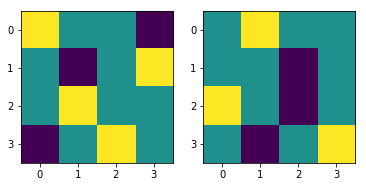

In [4]:
# try again with bad_syn set to the first :SY, :SX taps from the chip data

from pystorm.hal import HAL
HAL = HAL()
bad_syn = HAL.get_calibration('synapse', 'high_bias_magnitude')

yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=bad_syn.loc[:SY, :SX])

plt.figure()
plt.imshow(bad_syn.values.reshape((32, 32))[:SY, :SX])

if D == 1:
    plt.figure()
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])

In [5]:
# now that we know that works, try the whole thing

net_builder = NetBuilder(HAL)

tap_matrix = NetBuilder.syn_taps_to_nrn_taps(yx_taps)
NetBuilder.make_taps_even(tap_matrix)

net = net_builder.create_single_pool_net(Y, X, tap_matrix)
pool = net.get_pools()[0]
inp = net.get_inputs()[0]

# map the network
print("mapping network")
HAL.map(net)

# do it!
print("running encoders and offsets experiment")
est_encs, est_offsets, baselines, mean_residuals, insufficient_samples = \
    net_builder.determine_encoders_and_offsets(pool, inp, FMAX)

mapping network
running encoders and offsets experiment
getting baseline firing rates of population
running sample sweep at sample_angle = 0.7853981633974483 rad
  taking 36 sample points for 6 unique encs
  will run for 0.6 min.
doing spike processing
estimating encoders
6 neurons still need more points
running sample sweep at sample_angle = 0.39269908169872414 rad
  taking 18 sample points for 3 unique encs
  will run for 0.3 min.
doing spike processing
estimating encoders
4 neurons still need more points


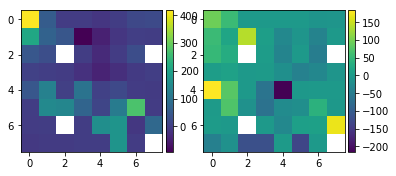

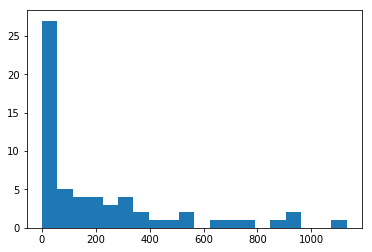

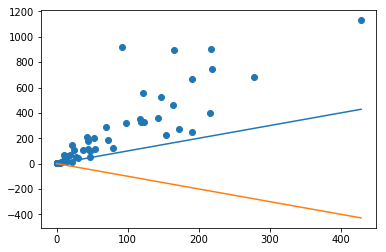

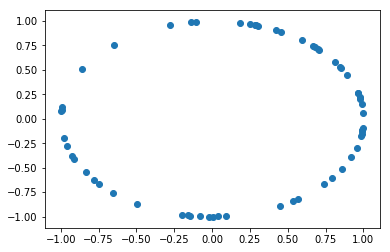

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

if D == 1:
    plt.figure()
    plt.imshow(est_encs.reshape(Y, X))
    plt.colorbar()
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        im = ax[d].imshow(est_encs[:, d].reshape(Y, X))
        divider = make_axes_locatable(ax[d])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
plt.figure()
plt.hist(est_offsets[~np.isnan(est_offsets)], bins=20)

gain = np.linalg.norm(est_encs, axis=1)
bias = est_offsets

plt.figure()
plt.scatter(gain, bias)
x = np.linspace(0, max(gain), 100)
plt.plot(x, x)
plt.plot(x, -x)

unit_encs = (est_encs.T / gain).T

plt.figure()
plt.scatter(unit_encs[:, 0], unit_encs[:, 1])



In [28]:
# validate estimated encoders and offsets

NUM_VAL_SAMPLES = 20
val_pts = np.random.randn(NUM_VAL_SAMPLES, D)
val_pts_norms = np.linalg.norm(val_pts, axis=1)
val_pts = (val_pts.T / val_pts_norms).T

rmse, meas_A, est_A = net_builder.validate_est_encs(est_encs, est_offsets, pool, inp, val_pts, FMAX)

276419 total spikes
(20001, 64)
[1100820110000 1102497110000 1104174110000 1105851110000 1107528110000
 1109205110000 1110882110000 1112559110000 1114236110000 1115913110000
 1117590110000 1119267110000 1120944110000 1122621110000 1124298110000
 1125975110000 1127652110000 1129329110000 1131006110000 1132683110000
 1134360110000]
start 13847
end 14347
8477 in bin
start 14900
end 15400
5232 in bin
start 15953
end 16453
5193 in bin
start 17005
end 17505
5733 in bin
start 18058
end 18558
6871 in bin
start 19111
end 19611
5200 in bin
start 20163
end 20663
0 in bin
start 21216
end 21716
0 in bin
start 22269
end 22769
0 in bin
start 23321
end 23821
0 in bin
start 24374
end 24874
0 in bin
start 25426
end 25926
0 in bin
start 26479
end 26979
0 in bin
start 27532
end 28032
0 in bin
start 28584
end 29084
0 in bin
start 29637
end 30137
0 in bin
start 30690
end 31190
0 in bin
start 31742
end 32242
0 in bin
start 32795
end 33295
0 in bin
start 33543
end 33543
0 in bin
73412.0 total after binning


Text(0.5,1,'diff')

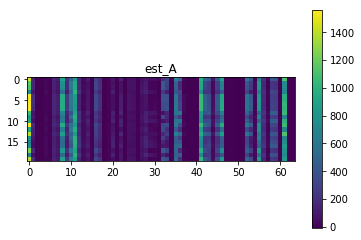

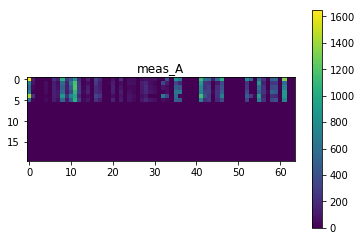

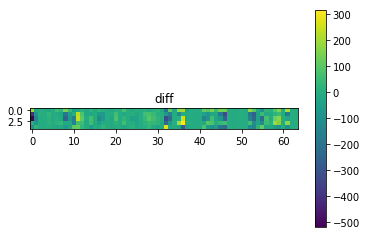

In [31]:
clean_encs = est_encs.copy()
unest = np.isnan(est_offsets)
clean_encs[unest, :] = 0
clean_offsets = est_offsets.copy()
clean_offsets[unest] = baselines[unest]

est_A = np.dot(val_pts, clean_encs.T) + clean_offsets

RMSE = np.sqrt(np.mean((est_A.flatten() - meas_A.flatten())**2))

plt.figure()
plt.imshow(est_A)
plt.colorbar()
plt.title('est_A')

plt.figure()
plt.imshow(meas_A)
plt.colorbar()
plt.title('meas_A')

plt.figure()
plt.imshow(meas_A - est_A)
plt.colorbar()
plt.title('diff')